# Multi-point stress approximation (MPSA)

Porepy supports mpsa discretization for linear elasticity problem:
\begin{equation}
\nabla\cdot \sigma = f.
\end{equation}
Conservation of momentum gives us for each control volume $\Omega_k$
\begin{equation}
-\int_{\Omega_k} f dv = \int_{\partial\Omega_k} T(n)dA,
\end{equation}
where $T(n) = \sigma \cdot n$ are the surface traction vectors on the boundary of the control volume.


To solve this system we first have to create the grid. Then we need to define boundary conditions. We set the bottom boundary as a Dirichlet boundary. The other boundaries are set to Neuman. We also need to create the stiffness matrix:

In [1]:
import numpy as np
import porepy as pp

# Create grid
n = 5
g = pp.CartGrid([n,n])
g.compute_geometry()

# Define boundary type
dirich = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))
bound = pp.BoundaryCondition(g, dirich, ['dir']*dirich.size)

# Create stiffness matrix
lam = np.ones(g.num_cells)
mu = np.ones(g.num_cells)
constit = pp.FourthOrderTensor(g.dim, mu, lam)

We here use the constitutive law:
\begin{equation}
\sigma = 2  \mu  \epsilon +\lambda  \text{trace}(\epsilon) I, \quad \epsilon = \frac{1}{2}(\nabla u + (\nabla u)^\top)
\end{equation}

We discretize the stresses by using the multi-point stress approximation (for details, please see: E. Keilegavlen and J. M. Nordbotten. “Finite volume methods for elasticity with weak symmetry”. In: International Journal for Numerical Methods in Engineering (2017)).

We now define the boundary conditions. We clamp the bottom boundary, and push down by a constant force on the top boundary. Note that the traction on the Neumann boundary is the total traction, not the traction density. To get the traction density we have to scale the traction by the face areas.

In [2]:
top_faces = np.ravel(np.argwhere(g.face_centers[1] > n - 1e-10))
bot_faces = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))

u_b = np.zeros((g.dim, g.num_faces))
u_b[1, top_faces] = -1 * g.face_areas[top_faces]
u_b[:, bot_faces] = 0

u_b = u_b.ravel('F')

We discretize this system using the Mpsa class. We assume zero body forces $f=0$

In [3]:
mpsa_class = pp.Mpsa("mechanics")
f = np.zeros(g.dim * g.num_cells)

param = pp.Parameters(g)
param.set_tensor("mechanics", constit)
param.set_bc("mechanics", bound)
param.set_bc_val("mechanics", u_b)
param.set_source("mechanics", f)
data = {'param': param}

A, b = mpsa_class.matrix_rhs(g, data)

u_class = np.linalg.solve(A.A, b)

And we can plott the y_displacement

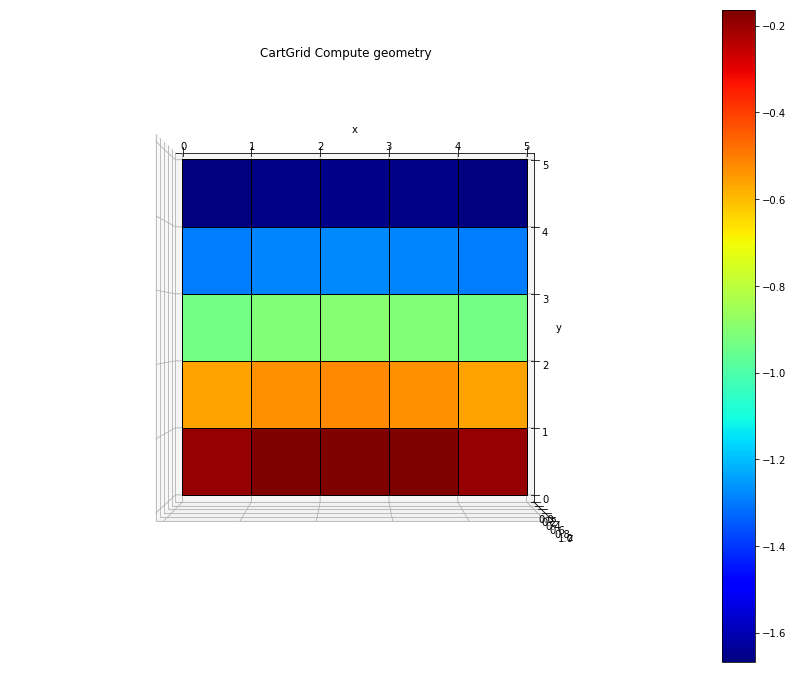

In [4]:
pp.plot_grid(g, cell_value=u_class[1::2], figsize=(15, 12))

To better understand what goes on under the hood of the mpsa class, we manually create the lhs and rhs

In [5]:
constit = pp.FourthOrderTensor(g.dim, mu, lam)
stress, bound_stress = pp.numerics.fv.mpsa.mpsa(g, constit, bound)

MPSA returns the two sparse matrices "stress" and "bound_stress". They give define the discretization of the cell-face traction:
\begin{equation}
T = \text{stress} \cdot u + \text{bound_stress} \cdot u_b
\end{equation}
Here $u$ is a vector of cell center displacement and has length g.dim $*$ g.num_cells. The vector $u_b$ is the boundary condition values. It is the displacement for Dirichlet boundaries and traction for Neumann boundaries and has length g.dim $*$ g.num_faces.


We are now ready to set up the linear system of equations and solve it. We define the body forces $f = 0$. Each row in the discretized system is now
\begin{equation}
-\int_{\Omega_k} f dv = \int_{\partial\Omega_k} T(n)dA = [div \cdot \text{stress} \cdot u + div\cdot\text{bound_stress}\cdot u_b]_k,
\end{equation}
We move the known boundary variable $u_b$ over to the right hand side and solve the system:


In [6]:
f = np.zeros(g.dim * g.num_cells)

div = pp.fvutils.vector_divergence(g)
A = div * stress
b = -f - div * bound_stress * u_b

u = np.linalg.solve(A.A, b)

This gives the same displacement as for the Mpsa class:

In [7]:
assert np.allclose(u, u_class)

We can now plot the y-displacement

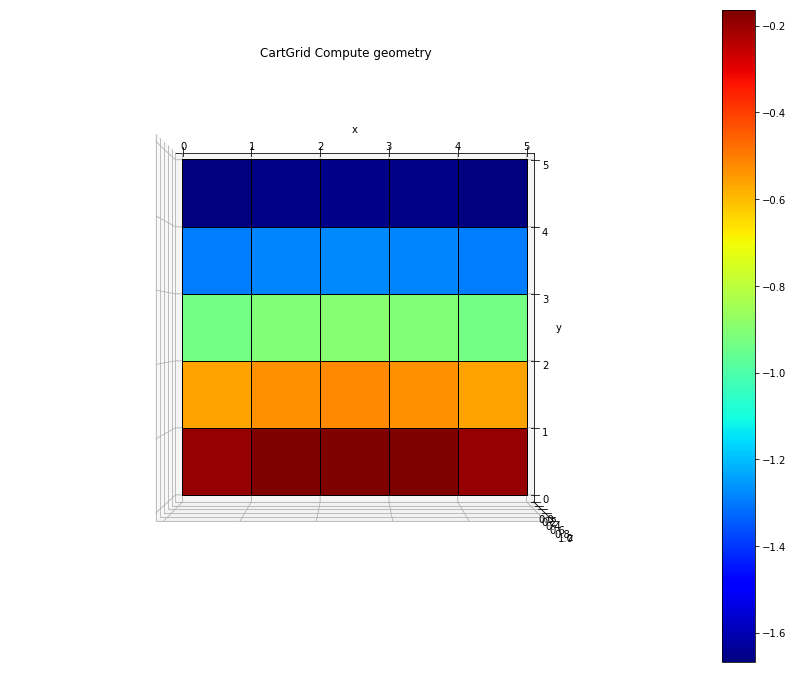

In [8]:
pp.plot_grid(g, cell_value=u[1::2], figsize=(15, 12))

We can also retrieve the traction on the faces. 

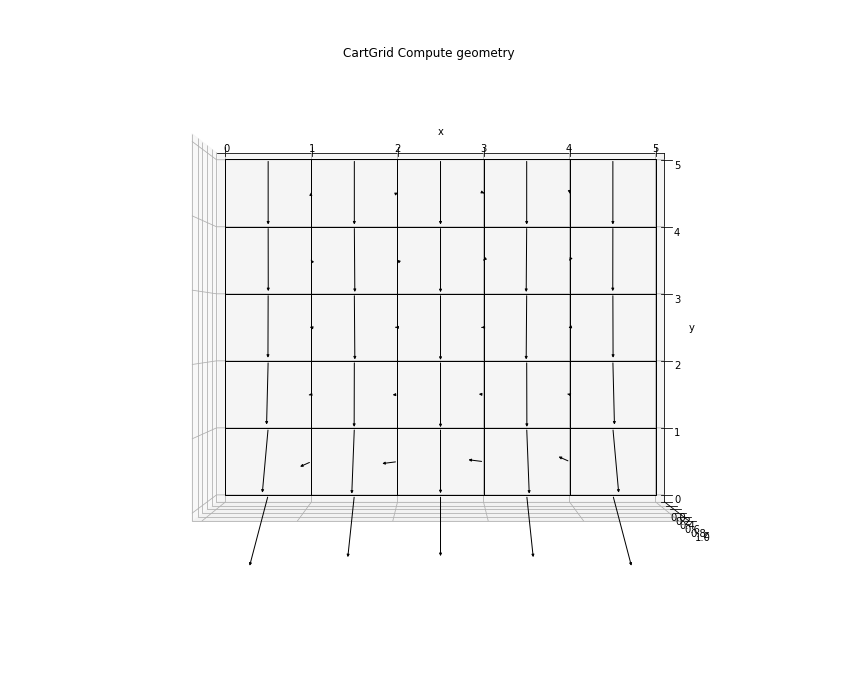

In [9]:
T = stress * u + bound_stress * u_b

neumann_faces = np.argwhere(bound.is_neu)
neumann_dof = np.ravel((2*neumann_faces, 2*neumann_faces+1),'F')

assert np.allclose(np.abs(u_b[neumann_dof]), np.abs(T[neumann_dof]))

T = np.vstack((T.reshape((g.dim, -1),order='F'), np.zeros(g.num_faces)))
pp.plot_grid(g, vector_value=50*T, figsize=(15, 12), alpha=0)

Note that the traction on face i: T[2*i:2*i+g.dim] is the traction on the face as defined by the normal vectors g.face_normals. This means that for the bottom boundary, the traction T[bot] is the force from to box on the outside (since the normal vectors here are [0,1]), while on the top boundary, the traction T[top] is the force applied to to top faces from the outside (since the normals here point out of the domain).